# Advanced dimensionality reduction methods
This tutorial will provide a high-level overview of some of the more advanced techniques for dimensionality reduction. We will be using the [handwritten digits data set](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), which is a collection of images of handwritten digits between 0 and 9. The data was generated by a total of 43 people, who wrote a total of 5620 digits by hand which were then digitized and processed into 8x8 greyscale images.

**Please note**: most of the code has been taken directly from [this example code](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#), which contains a few other examples of dimensionality reduction techniques, in addition to those expanded on here.

In [1]:
from time import time
import numpy as np
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

## Loading and inspecting the data
The digits data set is included as part of the sk-learn library, which makes loading it into our notebook a breeze. For this tutorial, we will simplify things by only looking at the first 6 digits in the data set. We can use the `n_class` argument in the `load_digits()` function to select only the numbers from 0 to 5.

In [3]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

In [4]:
print("Total number of samples: ", n_samples)
print("Features per sample: ", n_features)

Total number of samples:  1083
Features per sample:  64


### Images as data   
In the image below, the image on the left can be represented as a 14x14 array of pixels, with values ranging between 0 (white) and 1 (black).   

![mnist-array](https://tensorflow.rstudio.com/tensorflow/articles/images/MNIST-Matrix.png)   
(Source [: TensorFlow for R](https://tensorflow.rstudio.com/tensorflow/articles/tutorial_mnist_beginners.html))   

The same concept applies to our data set, only the arrays are a little smaller (8x8) and they have been strung out into single rows of 64 values, ranging between 0 and 16. Let's take a look at the first digit in the data:

In [5]:
X[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [6]:
# what digit is this?
y[0]

0

## Plotting the data
Could you tell that the first array was a zero? Unless you are some sort of savant genius, you probably weren't be able to tell which digit is represented by the array above.   

Luckily, we can use the `imshow()` function from the matplotlib library to plot these digits:

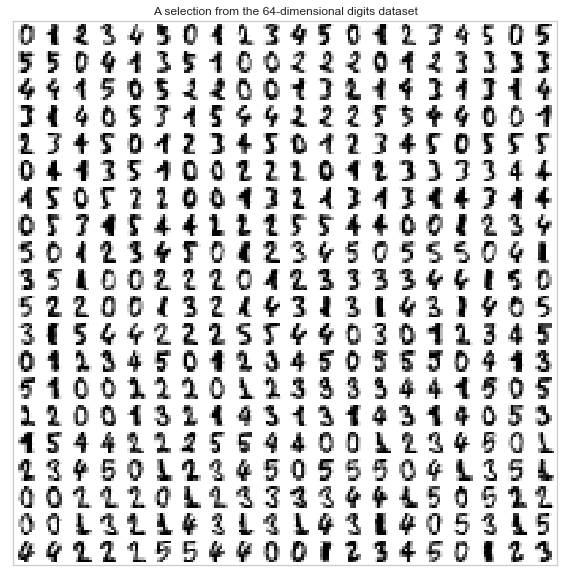

In [7]:
# Plot images of the digits
n_img_per_row = 20

# create a large grid of zeros
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))

# for each column
for i in range(n_img_per_row):
    
    # find the x-coordinate
    ix = 10 * i + 1
    
    # for each row 
    for j in range(n_img_per_row):
        
        # find the y-coordiante
        iy = 10 * j + 1
        
        # change the pixels in this part of the grid to match the digit
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

# plt the grid as a single image
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

## Dimensionality reduction
Now, what we are going to try and do is reduce the dimensionality of the entire data set to just two dimensions. We will use a few different dimensionality reduction techniques, and at each stage we will plot the data and see how it is distributed in these two dimensions.   

What is very important to note here is that none of these algorithms will be shown the labels of the data; they will be entirely unsupervised. In each case, we will plot the data in two dimensions, but include the known labels of the data points in the plots for our own validation.   

For plotting, we are going to use the same `plot_embedding()` function defined in the original Sk-learn example code. This does a fantastic job of plotting the digits in two-dimensional space, so there is no need to reinvent the wheel here.   

NOTE: You will see the word **"embedding"** used in some of the comments and plots below. Simply put, an embedding is a representation of a vector in a different feature space. So in this case, the original digits exist as 64-dimensional arrays and are then reduced to just 2 dimensions. The resulting 2-dimensional vectors are reffered to as the embedding vectors.

In [8]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    
    # normalise data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    
    ax = plt.subplot(111)
    
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

### Principal Component Analysis (PCA)
PCA was covered in a previous tutorial, so we won't go into great detail about it here. We know that the objective of PCA is to decompose a data set into mutually orthogonal components, that **best maintain the total variance in the data set**.   

We will use PCA to decompose the data set into the first two principal components, which will contain the largest and second largest amounts of variance, respectively.

In [14]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.PCA(n_components=2).fit_transform(X)
t1 = time()

Computing PCA projection


Now, before using the awesome `plot_embedding()` function, let's plot the data, without labels, in the first two principal components.

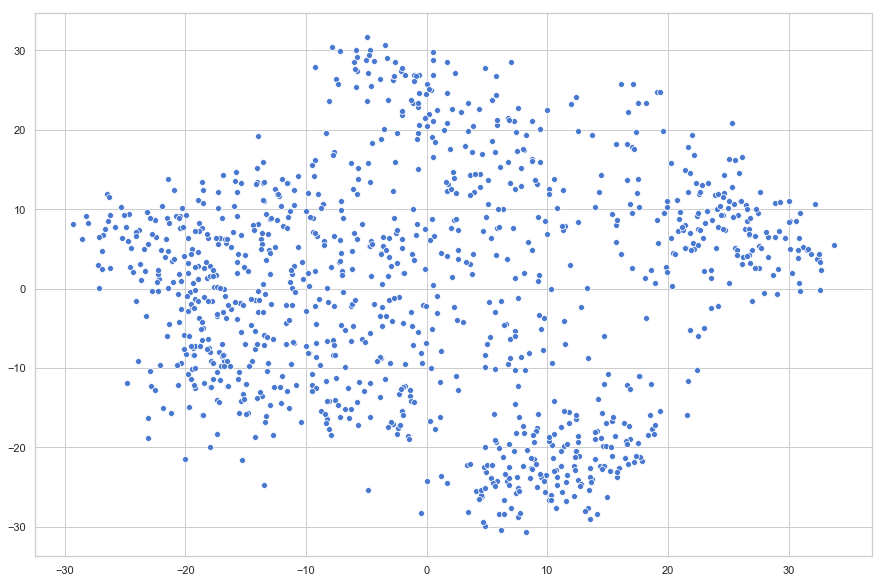

In [15]:
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                     sizes=(10, 200))
plt.show()

Can you spot any obvious clusters? Perhaps one or two on the right side of the plot?   

Now, let's plot the data with labels:

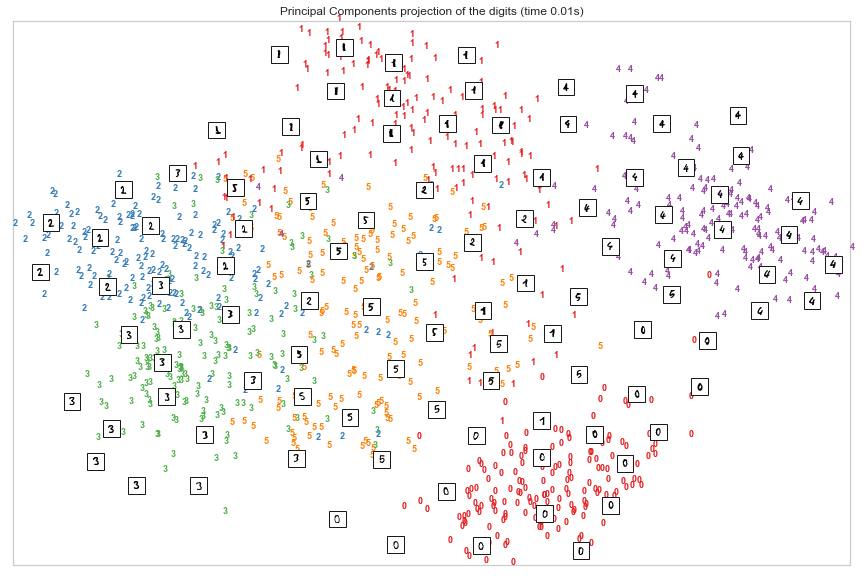

In [16]:
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (t1 - t0))
plt.show()

So we can see that digits do seem to group together, but there isn't the clearest of separation between the different digits.   

Now, let's take a look at some other techniques and see how they perform.   

### Multi-dimensional Scaling (MDS)
The goal of MDS is to map features to a low-dimensional space, **while preserving the distances** between observations in a given data set.   

MDS can be performed using algorithms that are either *metric* or *non-metric*. Non-metric approaches are typically used to preserve ordinality within data. This is more of a necessity when there are categorical features present in the data. Since the data used here is entirely numeric, we will use a metric approach.   

The **stress** is a measure of the difference between the distances between points in the original feature space and the distances in the low-dimensional space. It is this quantity that is minimised by MDS.   

For more information on MDS, read the [Sk-learn user guide](https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling).

In [17]:
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, 
                   n_init=4, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
t0 = time()
X_mds = clf.fit_transform(X)
t1 = time()
print("Done. Stress: %f" % clf.stress_)

Computing MDS embedding
Done. Stress: 134251964.793077


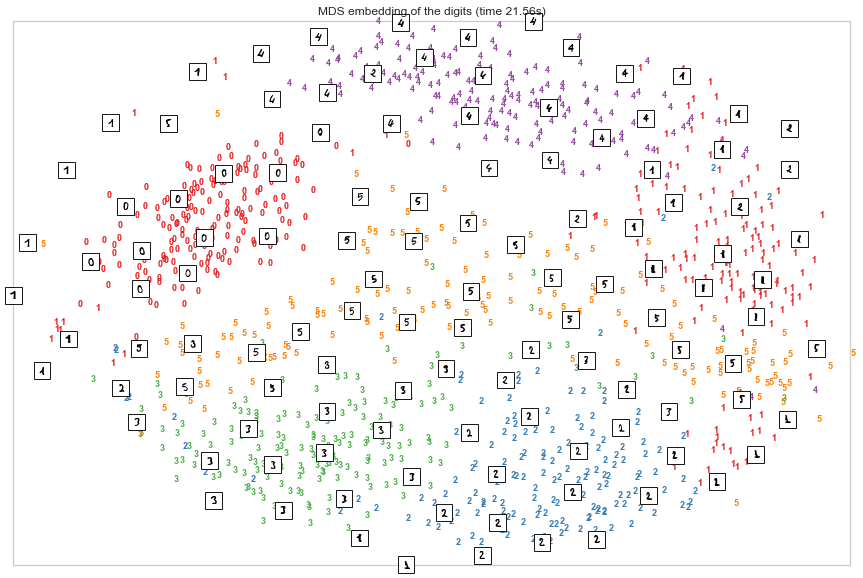

In [18]:
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (t1 - t0))

### t-distributed Stochastic Neighbour Embedding (t-SNE)
t-SNE is a very complex technique, which can often yield truly stunning results when reducing high-dimensional data sets. Here is a pretty good explanation of t-SNE from [Wikipedia](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding):   
> "The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the two distributions with respect to the locations of the points in the map. Note that whilst the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this should be changed as appropriate."   

Additionally, you can watch the video below for a more detailed explanation of how t-SNE works:

In [19]:
from IPython.display import IFrame

# Youtube
IFrame(width="840", height="472", src="https://www.youtube.com/embed/NEaUSP4YerM")

We won't get into the finer details here. Instead, here is a summary of the important points of t-SNE:   
  - non-linear transformation
  - preserves both local and global structure (usually)
  - computationally expensive

For more information on t-SNE, check out the [Sk-learn user guide](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne) or read through any of the articles below:   
  - **O'Reilly**: [An illustrated introduction to the t-SNE algorithm](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm)
  - **Analytics Vidhya**: [Comprehensive guide on t-SNE algorithm with implementation in R & Python](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)
  - **DataCamp**: [Introduction to t-SNE](https://www.datacamp.com/community/tutorials/introduction-t-sne)

In [20]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)
t0 = time()
X_tsne = tsne.fit_transform(X)
t1 = time()

Computing t-SNE embedding
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1083 samples in 0.004s...
[t-SNE] Computed neighbors for 1083 samples in 0.394s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1083
[t-SNE] Computed conditional probabilities for sample 1083 / 1083
[t-SNE] Mean sigma: 8.449599
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.448616
[t-SNE] KL divergence after 1000 iterations: 0.553890


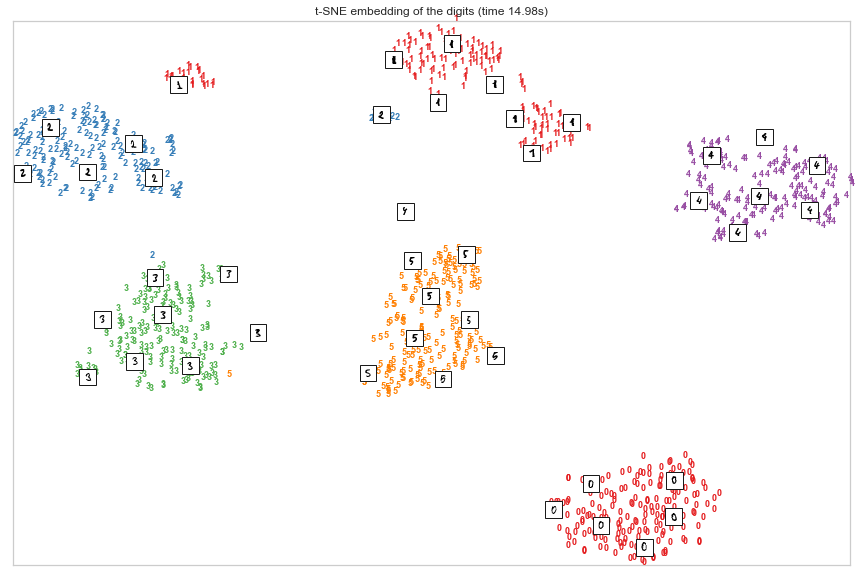

In [21]:
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (t1 - t0))

plt.show()

Wow, how cool is that?!   

Remember, the algorithm made no use of the labels. The digit arrays were reduced into 2-dimensional space where similar digits ended up close together. We have five main clusters - one for each digit class. But we also have a few smaller clusters, notice the small group of twos that are somewhere between the 1s and the rest of the 2s? Or the 1s that are quite close to the 2s?   

### Final word of caution
In this case, we have demonstrated the power of t-SNE as a tool for exploratory data analysis and its power to reveal natural groups, or clusters, within data sets.   

However, t-SNE can also be very misleading at times and you are encouraged to investigate the effects of the various hyperparameters of the results when working with different data sets.   

Check out [this article](https://distill.pub/2016/misread-tsne/) for some insights into t-SNE's various hyperparameters.